### 07a. Testing CT Modality-Based Demand Models

This notebook aims to model and predict healthcare demand based on patient demographics and clinical indicators, specifically focusing on different **modalities** of service. The primary goal is to evaluate various statistical and machine learning models for their ability to predict demand, with a focus on the following input features:

- **Age segments** (e.g., binned or continuous)  
- **Patient source**  
- **Elective vs emergency flag**  
- **Cancer flag**

We will begin with simple aggregate modeling and progressively test more complex models:

1. **Naïve mean** – simple average demand per segment  
2. **GLM** – Generalized Linear Model  
3. **GLM with interactions** – e.g., age × cancer flag  
4. **GAM** – Generalized Additive Model  
5. **Random Forest** – tree-based machine learning model

Each model will be tested per modality, and performance will be evaluated using an 80/20 train-test split with the following metrics:

- Mean Absolute Error (MAE)  
- Root Mean Squared Error (RMSE)  
- R² or Deviance explained (for GLM/GAM)

The overall aim is to understand which modeling approach best captures the relationship between demographic/clinical inputs and demand, and how this varies by modality.


In [1]:
import sys
!{sys.executable} -m pip install pygam

# Data Handling
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling - GLM, GAM, RF
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from pygam import LinearGAM, s, f  # For Generalized Additive Models

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Optional - for hierarchical modeling if extended
# import pymc3 as pm  # Uncomment if you plan to use Bayesian hierarchical models

In [6]:
# Set base path
base_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed"

# File paths
ct_master_path = os.path.join(base_path, "ct_master.csv")
modality_counts_path = os.path.join(base_path, "modality_procedure_counts_by_age_band_2024.csv")
population_path = os.path.join(base_path, "south_west_population_2024.csv")

# Load CSVs
ct_master_df = pd.read_csv(ct_master_path)
modality_counts_df = pd.read_csv(modality_counts_path)
population_df = pd.read_csv(population_path)

# Display basic checks
print("CT Master Data - Columns:")
print(ct_master_df.columns.tolist())
print("\nHead:")
print(ct_master_df.head(), "\n")

print("Modality Procedure Counts by Age Band 2024 - Columns:")
print(modality_counts_df.columns.tolist())
print("\nHead:")
print(modality_counts_df.head(), "\n")

print("South West Population 2024 - Columns:")
print(population_df.columns.tolist())
print("\nHead:")
print(population_df.head())

CT Master Data - Columns:
['icb_code', 'icb_name', 'lsoa_code', 'nhs_region', 'site_code', 'site_name', 'provider_code', 'provider_name', 'activity_month', 'financial_year', 'financial_month', 'test_date', 'age', 'sex', 'modality', 'sub_modality', 'procedure_name', 'referral_type', 'patient_source', 'cancer_flag', 'subcancer_flag', 'referring_org_code', 'referring_org_name', 'age_band', 'age_mid', 'modality_clean', 'ps_bucket', 'is_ct', 'is_mri', 'is_endo']

Head:
  icb_code                icb_name  lsoa_code  \
0      11X  NHS SOMERSET ICB - 11X  E01029112   
1      11X  NHS SOMERSET ICB - 11X  E01029135   
2      11X  NHS SOMERSET ICB - 11X  E01029237   
3      11X  NHS SOMERSET ICB - 11X  E01029255   
4      11X  NHS SOMERSET ICB - 11X  E01029205   

                        nhs_region site_code                       site_name  \
0  Head structure (body structure)     RH5A8  MUSGROVE PARK HOSPITAL (RH5A8)   
1  Head structure (body structure)     RH5A8  MUSGROVE PARK HOSPITAL (RH5A8)

In [7]:
# Naïve Mean Model (Aggregate Baseline) for CT

# Load modality procedure counts
modality_counts_df = pd.read_csv(modality_counts_path)

# Define 2024 population projection by age band
age_band_population = pd.DataFrame({
    "age_band": [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
        "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
        "75-79", "80-84", "85+"
    ],
    "population_2024": [
        283792, 322018, 331416, 324765, 342425, 342688, 367510, 355513,
        341210, 362553, 413048, 423510, 376552, 337298, 357074,
        266939, 181501, 183436
    ]
})

# Step 1: Extract age_band and CT_Total
ct_df = modality_counts_df[['age_band', 'CT_Total']].copy()

# Step 2: Merge with population data
ct_df = ct_df.merge(age_band_population, on='age_band', how='left')

# Step 3: Calculate demand per 10k and per 1k
ct_df['ct_demand_per_10k'] = (
    ct_df['CT_Total'] / ct_df['population_2024']
) * 10000

ct_df['ct_demand_per_1k'] = (
    ct_df['CT_Total'] / ct_df['population_2024']
) * 1000

# Optional: Round for readability
ct_df[['ct_demand_per_10k', 'ct_demand_per_1k']] = \
    ct_df[['ct_demand_per_10k', 'ct_demand_per_1k']].round(2)

# Display result
print(ct_df)


   age_band  CT_Total  population_2024  ct_demand_per_10k  ct_demand_per_1k
0       0-4      2041           283792              71.92              7.19
1       5-9      1410           322018              43.79              4.38
2     10-14      2850           331416              85.99              8.60
3     15-19      7081           324765             218.03             21.80
4     20-24     10327           342425             301.58             30.16
5     25-29     12782           342688             372.99             37.30
6     30-34     17036           367510             463.55             46.36
7     35-39     20153           355513             566.87             56.69
8     40-44     23951           341210             701.94             70.19
9     45-49     26175           362553             721.96             72.20
10    50-54     38165           413048             923.98             92.40
11    55-59     53889           423510            1272.44            127.24
12    60-64 

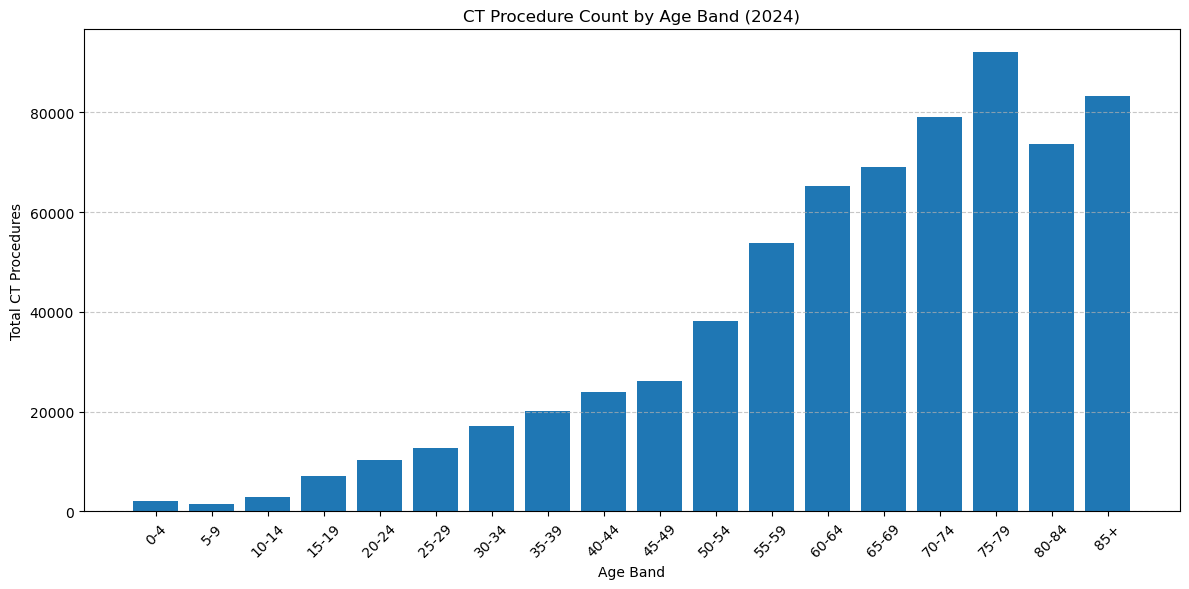

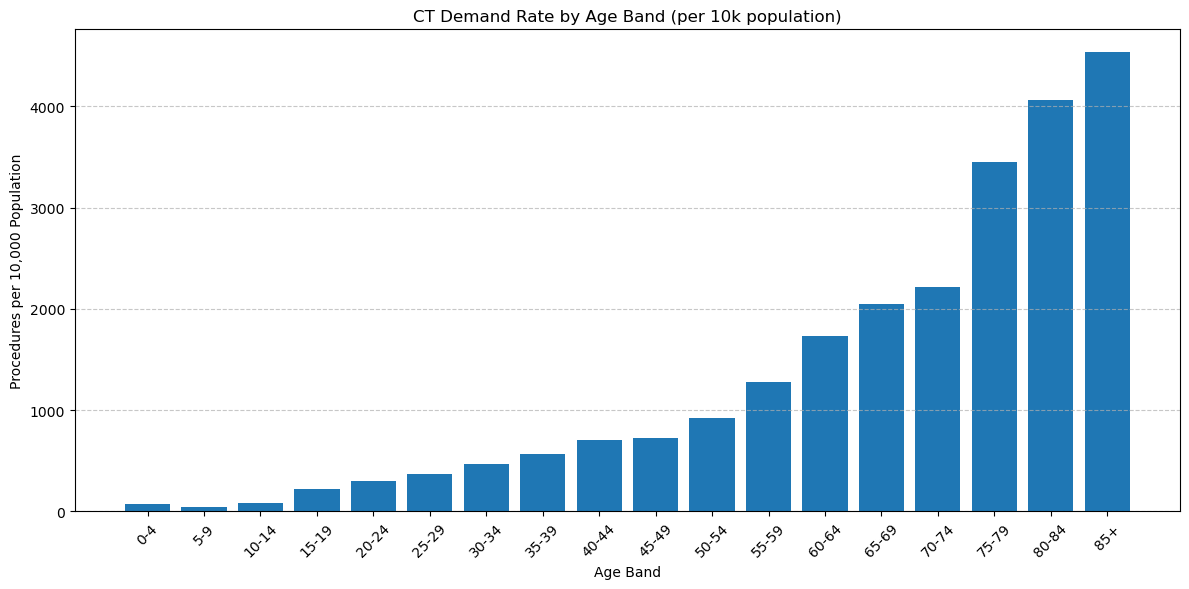

In [8]:
# Visualisation: CT Procedure Volume and Demand Rate by Age Band

# Plot 1: Total CT Procedures by Age Band
plt.figure(figsize=(12, 6))
plt.bar(ct_df['age_band'], ct_df['CT_Total'])
plt.xlabel('Age Band')
plt.ylabel('Total CT Procedures')
plt.title('CT Procedure Count by Age Band (2024)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: CT Demand Rate (per 10,000 population) by Age Band
plt.figure(figsize=(12, 6))
plt.bar(ct_df['age_band'], ct_df['ct_demand_per_10k'])
plt.xlabel('Age Band')
plt.ylabel('Procedures per 10,000 Population')
plt.title('CT Demand Rate by Age Band (per 10k population)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Sum of CT demand PDF over age bands: 1.000000


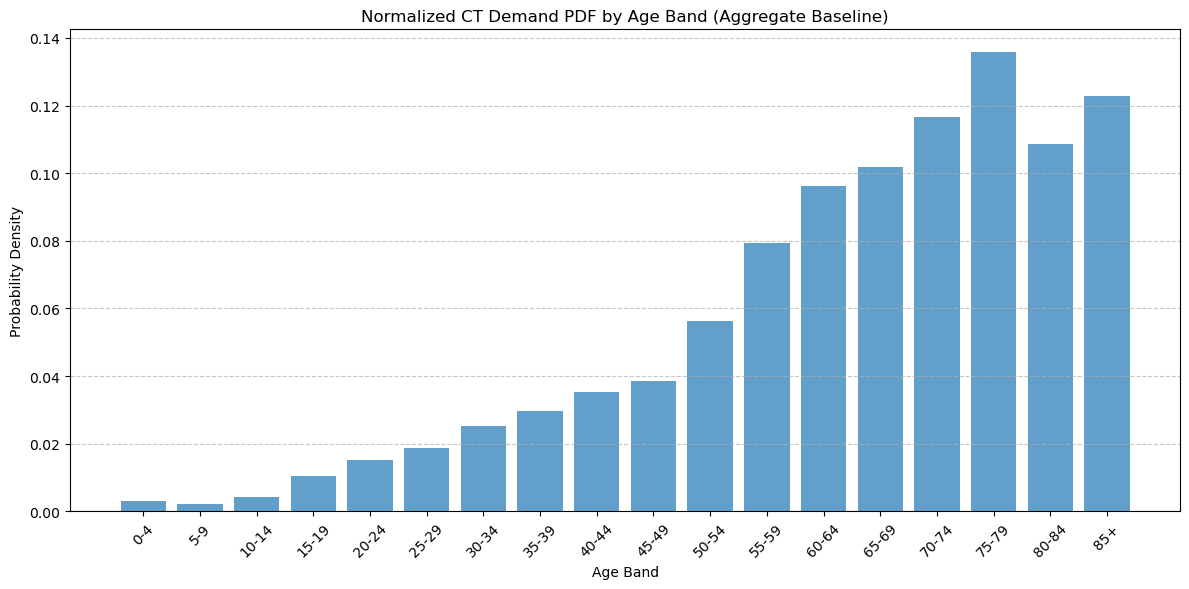

In [9]:
# Step 1: Calculate total CT demand per age band (demand per 1k * population / 1000)
ct_df['total_demand'] = (ct_df['ct_demand_per_1k'] * ct_df['population_2024']) / 1000

# Step 2: Normalize total demand to create a PDF over age bands
total_demand_sum = ct_df['total_demand'].sum()
ct_df['demand_pdf'] = ct_df['total_demand'] / total_demand_sum

# Step 3: Confirm that the PDF sums to 1
print(f"Sum of CT demand PDF over age bands: {ct_df['demand_pdf'].sum():.6f}")

# Step 4: Visualise the demand PDF
plt.figure(figsize=(12, 6))
plt.bar(ct_df['age_band'], ct_df['demand_pdf'], alpha=0.7)
plt.xlabel('Age Band')
plt.ylabel('Probability Density')
plt.title('Normalized CT Demand PDF by Age Band (Aggregate Baseline)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [10]:
# Naïve Model (Continuous Age) for CT

# Step 1: Filter CT records
ct_df_cont = ct_master_df[ct_master_df['is_ct'] == 1].copy()

# Step 2: Load population data (expects columns: 'age', 'population')
population_df = pd.read_csv(population_path)
population_df.rename(columns={'population': 'population_2024'}, inplace=True)

# Step 3: Count CT procedures by age
ct_by_age = ct_df_cont.groupby('age').size().reset_index(name='CT_Total')

# Step 4: Merge with population data
merged_df = ct_by_age.merge(population_df, on='age', how='left')

# Step 5: Calculate demand per 10,000 and per 1,000
merged_df['ct_demand_per_10k'] = (merged_df['CT_Total'] / merged_df['population_2024']) * 10000
merged_df['ct_demand_per_1k'] = (merged_df['CT_Total'] / merged_df['population_2024']) * 1000

# Step 6: Round for readability
merged_df[['ct_demand_per_10k', 'ct_demand_per_1k']] = \
    merged_df[['ct_demand_per_10k', 'ct_demand_per_1k']].round(2)

# Optional: Sort by age for better readability
merged_df.sort_values('age', inplace=True)

# View result
print(merged_df.head())


   age  CT_Total  population_2024  ct_demand_per_10k  ct_demand_per_1k
0  0.0       785          52166.0             150.48             15.05
1  1.0       378          54517.0              69.34              6.93
2  2.0       244          56664.0              43.06              4.31
3  3.0       331          57911.0              57.16              5.72
4  4.0       299          59455.0              50.29              5.03


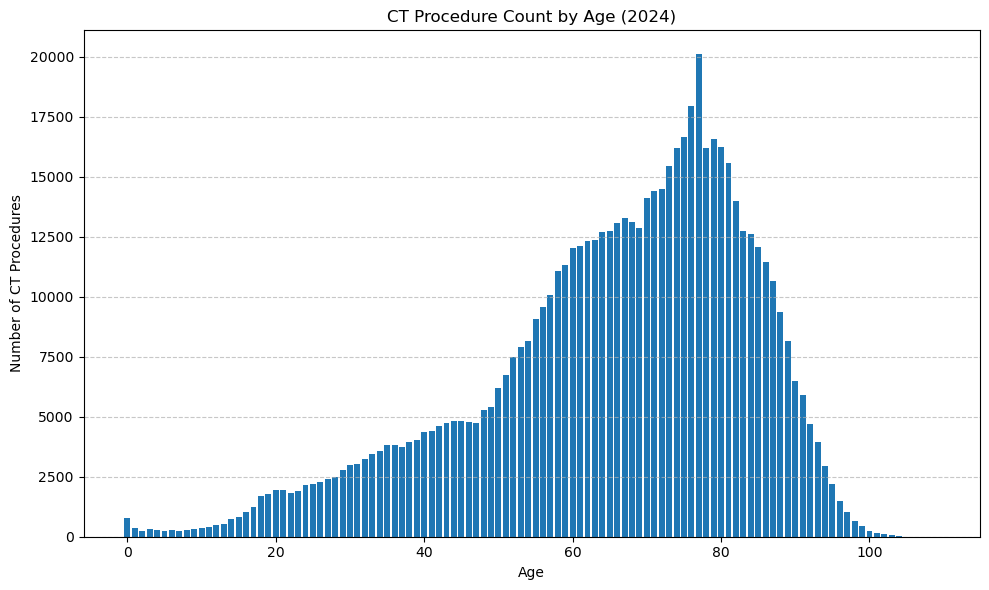

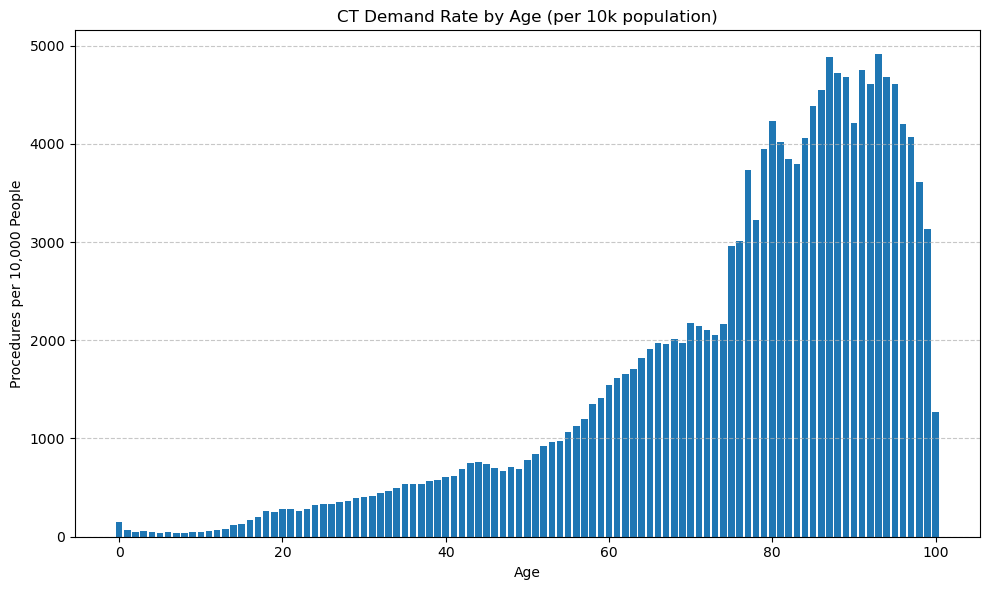

In [11]:
# Histogram of total CT procedures by age
plt.figure(figsize=(10, 6))
plt.bar(merged_df['age'], merged_df['CT_Total'], width=0.8)
plt.xlabel('Age')
plt.ylabel('Number of CT Procedures')
plt.title('CT Procedure Count by Age (2024)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Histogram of CT demand rate per 10,000 population by age
plt.figure(figsize=(10, 6))
plt.bar(merged_df['age'], merged_df['ct_demand_per_10k'], width=0.8)
plt.xlabel('Age')
plt.ylabel('Procedures per 10,000 People')
plt.title('CT Demand Rate by Age (per 10k population)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


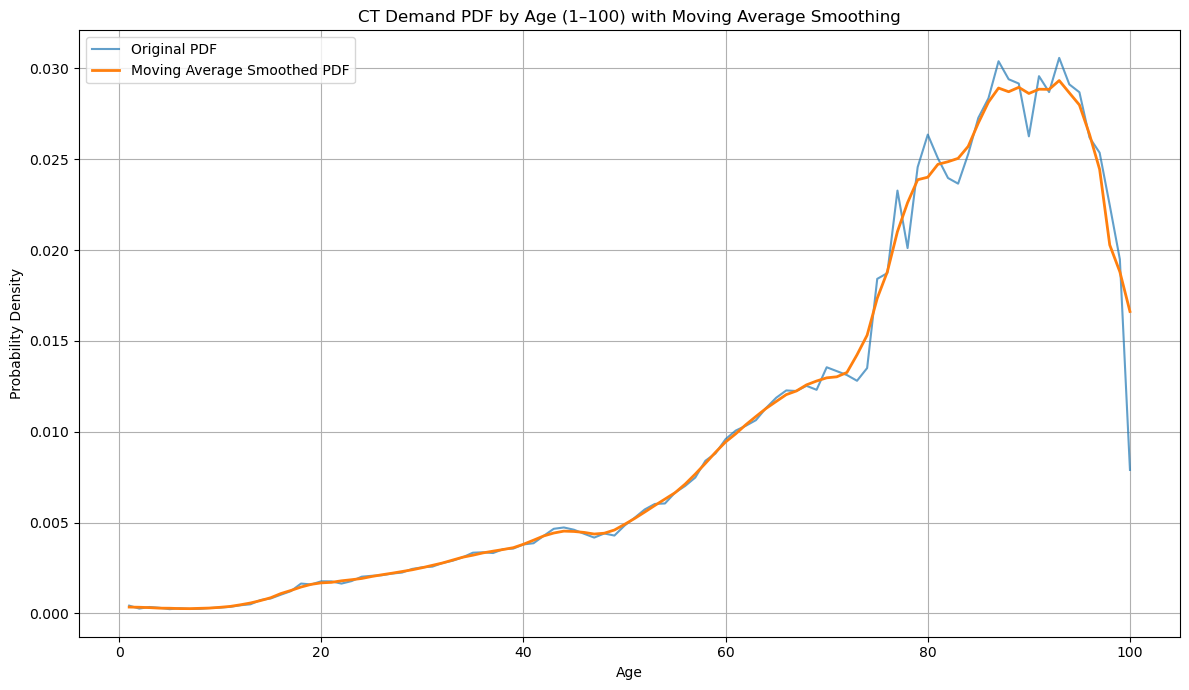

In [12]:
# Prepare full age range and merge with CT demand
full_age_range = pd.DataFrame({'age': np.arange(1, 101)})
merged_full = full_age_range.merge(merged_df[['age', 'ct_demand_per_1k']], on='age', how='left')
merged_full['ct_demand_per_1k'].fillna(0, inplace=True)

# Normalize to get PDF
demand = merged_full['ct_demand_per_1k'].values
pdf = demand / demand.sum()
merged_full['demand_pdf'] = pdf

# Apply moving average smoothing (window size = 5)
window_size = 5
smoothed_pdf = merged_full['demand_pdf'].rolling(window=window_size, center=True, min_periods=1).mean()
merged_full['smoothed_pdf'] = smoothed_pdf

# Plot raw and smoothed PDFs
plt.figure(figsize=(12, 7))
plt.plot(merged_full['age'], merged_full['demand_pdf'], label='Original PDF', alpha=0.7)
plt.plot(merged_full['age'], merged_full['smoothed_pdf'], label='Moving Average Smoothed PDF', linewidth=2)
plt.xlabel('Age')
plt.ylabel('Probability Density')
plt.title('CT Demand PDF by Age (1–100) with Moving Average Smoothing')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Step: Calculate % of total CT procedures by age group (50–100, 60–100, ..., 90–100)

# Total CT count across all ages
total_ct = merged_df['CT_Total'].sum()

# Define age band ranges
age_band_ranges = [
    (0, 49),
    (50, 100),
    (60, 100),
    (70, 100),
    (80, 100),
    (90, 100)
]
# Loop through bands and compute %
for start_age, end_age in age_band_ranges:
    ct_in_band = merged_df[merged_df['age'].between(start_age, end_age)]['CT_Total'].sum()
    percentage = (ct_in_band / total_ct) * 100
    print(f"Percentage of CT procedures for ages {start_age}–{end_age}: {percentage:.2f}%")


Percentage of CT procedures for ages 0–49: 18.22%
Percentage of CT procedures for ages 50–100: 81.73%
Percentage of CT procedures for ages 60–100: 68.20%
Percentage of CT procedures for ages 70–100: 48.65%
Percentage of CT procedures for ages 80–100: 23.62%
Percentage of CT procedures for ages 90–100: 4.64%


In [15]:
# ----------------------------------------------------------
#  Predicting CT Demand Rate per 1,000 People by Age
# ----------------------------------------------------------

# Step 1: Prepare data
model_df = merged_df.copy()
model_df.dropna(subset=["ct_demand_per_1k"], inplace=True)

# Step 2: Fit Poisson GLM (from statsmodels)
glm_model = smf.glm(
    formula="ct_demand_per_1k ~ age",
    data=model_df,
    family=sm.families.Poisson()
).fit()

# Step 3: Output GLM summary
print(glm_model.summary())

# Step 4: Store predictions
model_df["predicted_glm"] = glm_model.predict(model_df)

# Step 5: Fit Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(model_df[["age"]], model_df["ct_demand_per_1k"])
model_df["predicted_rf"] = rf_model.predict(model_df[["age"]])

# Step 6: Evaluate model performance
def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name:<20} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

evaluate(model_df["ct_demand_per_1k"], model_df["predicted_glm"], "Poisson GLM")
evaluate(model_df["ct_demand_per_1k"], model_df["predicted_rf"],  "Random Forest")


                 Generalized Linear Model Regression Results                  
Dep. Variable:       ct_demand_per_1k   No. Observations:                  101
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1057.1
Date:                Fri, 04 Jul 2025   Deviance:                       1489.9
Time:                        09:34:22   Pearson chi2:                 1.25e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6627      0.029     92.472      0.0

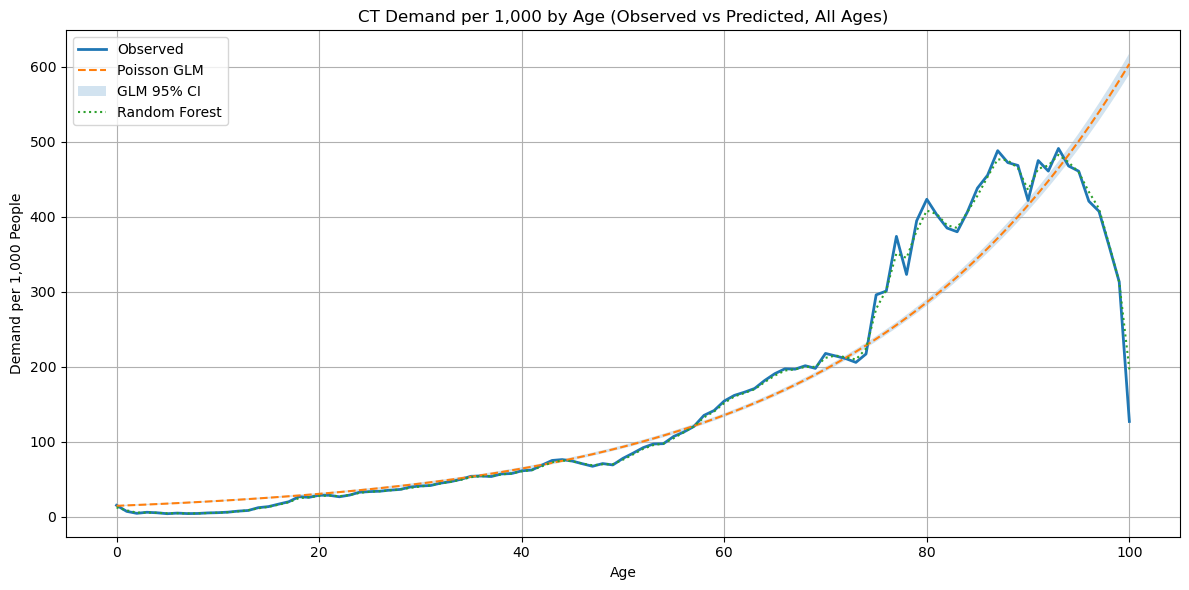

In [17]:
# Step 6: Confidence Intervals for Poisson GLM (all ages)
pred_summary = glm_model.get_prediction(model_df).summary_frame()
model_df["glm_ci_lower"] = pred_summary["mean_ci_lower"]
model_df["glm_ci_upper"] = pred_summary["mean_ci_upper"]

# Step 7: Rename columns for consistent plotting
model_df = model_df.rename(columns={
    "predicted_glm": "predicted_glm_1k",
    "predicted_rf": "predicted_rf_1k"
})

# Step 8: Sort for plotting across all ages
plot_df = model_df.sort_values(by="age")

# Step 9: Plot Observed vs Predicted (All Ages)
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x="age", y="ct_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=plot_df, x="age", y="predicted_glm_1k", label="Poisson GLM", linestyle="--")
plt.fill_between(
    plot_df["age"],
    plot_df["glm_ci_lower"],
    plot_df["glm_ci_upper"],
    alpha=0.2,
    label="GLM 95% CI"
)
sns.lineplot(data=plot_df, x="age", y="predicted_rf_1k", label="Random Forest", linestyle=":")
plt.title("CT Demand per 1,000 by Age (Observed vs Predicted, All Ages)")
plt.ylabel("Demand per 1,000 People")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Poisson GLM (Smoothed)         | MAE: 32.92 | RMSE: 69.13 | R²: 0.810
Random Forest (Smoothed)       | MAE: 7.39 | RMSE: 19.55 | R²: 0.985
Ensemble (Smoothed)            | MAE: 21.39 | RMSE: 47.01 | R²: 0.912


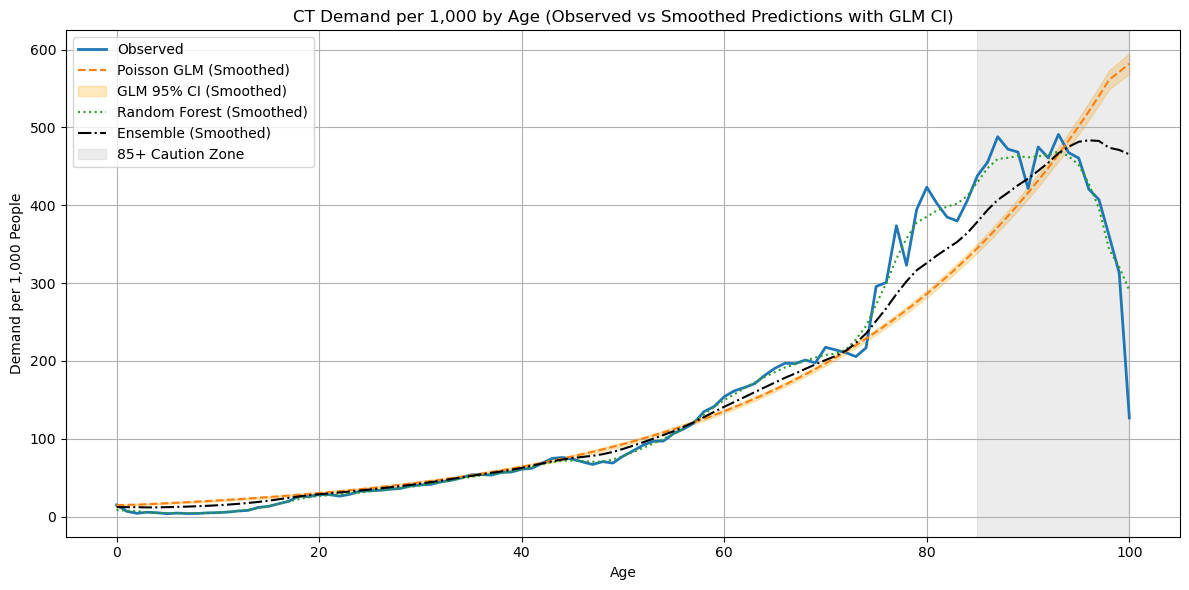

In [18]:
# Step 1: Prepare data
model_df = merged_df.copy()
model_df.dropna(subset=["ct_demand_per_1k"], inplace=True)

# Step 2: Poisson GLM (Statsmodels)
glm_model = smf.glm(
    formula="ct_demand_per_1k ~ age",
    data=model_df,
    family=sm.families.Poisson()
).fit()
model_df["predicted_glm"] = glm_model.predict(model_df)

# Get 95% confidence intervals for GLM predictions
predictions_glm = glm_model.get_prediction(model_df)
pred_summary = predictions_glm.summary_frame(alpha=0.05)  # 95% CI
model_df["glm_ci_lower"] = pred_summary["mean_ci_lower"]
model_df["glm_ci_upper"] = pred_summary["mean_ci_upper"]

# Step 3: Random Forest (Sklearn)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(model_df[["age"]], model_df["ct_demand_per_1k"])
model_df["predicted_rf"] = rf_model.predict(model_df[["age"]])

# Step 4: Ensemble Average (60% GLM, 40% RF)
model_df["predicted_ensemble"] = (
    0.6 * model_df["predicted_glm"] + 0.4 * model_df["predicted_rf"]
)

# Step 5: Apply Moving Average Smoothing (window=5)
window_size = 5
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df[f"{col}_smoothed"] = model_df[col].rolling(
        window=window_size, center=True, min_periods=1
    ).mean()

# Smooth CIs as well (for visual consistency)
model_df["glm_ci_lower_smoothed"] = model_df["glm_ci_lower"].rolling(
    window=window_size, center=True, min_periods=1
).mean()
model_df["glm_ci_upper_smoothed"] = model_df["glm_ci_upper"].rolling(
    window=window_size, center=True, min_periods=1
).mean()

# Step 6: Evaluation Function
def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name:<30} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

# Step 7: Evaluate All Models (using smoothed predictions)
evaluate(model_df["ct_demand_per_1k"], model_df["predicted_glm_smoothed"], "Poisson GLM (Smoothed)")
evaluate(model_df["ct_demand_per_1k"], model_df["predicted_rf_smoothed"], "Random Forest (Smoothed)")
evaluate(model_df["ct_demand_per_1k"], model_df["predicted_ensemble_smoothed"], "Ensemble (Smoothed)")

# Step 8: Visualise Smoothed Predictions with CI
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df, x="age", y="ct_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.fill_between(
    model_df["age"],
    model_df["glm_ci_lower_smoothed"],
    model_df["glm_ci_upper_smoothed"],
    color='orange',
    alpha=0.25,
    label="GLM 95% CI (Smoothed)"
)
sns.lineplot(data=model_df, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")
sns.lineplot(data=model_df, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

plt.axvspan(85, 100, color='grey', alpha=0.15, label="85+ Caution Zone")
plt.title("CT Demand per 1,000 by Age (Observed vs Smoothed Predictions with GLM CI)")
plt.ylabel("Demand per 1,000 People")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Filter CT records
ct_df_cont = ct_master_df[ct_master_df["is_ct"] == 1].copy()

# Drop rows with missing key fields
ct_df_cont = ct_df_cont.dropna(subset=["age", "cancer_flag", "patient_source"])

# Bin age into integers (if needed) and convert categorical variables
ct_df_cont["age"] = ct_df_cont["age"].astype(int)
ct_df_cont["cancer_flag"] = ct_df_cont["cancer_flag"].astype(str)  # ensure string
ct_df_cont["patient_source"] = ct_df_cont["patient_source"].astype("category")


In [20]:
# Load population (continuous)
population_df = pd.read_csv(population_path)
population_df.rename(columns={"population": "population_2024"}, inplace=True)

# Count CT procedures per (age, cancer_flag, patient_source)
grouped_df = ct_df_cont.groupby(["age", "cancer_flag", "patient_source"]).size().reset_index(name="CT_Total")

# Merge with population data by age
grouped_df = grouped_df.merge(population_df, on="age", how="left")
grouped_df = grouped_df.dropna(subset=["population_2024"])

# Calculate CT rate per 1,000 people
grouped_df["ct_demand_per_1k"] = (grouped_df["CT_Total"] / grouped_df["population_2024"]) * 1000


In [23]:
# Poisson GLM with categorical variables
glm_formula = "ct_demand_per_1k ~ age + C(cancer_flag) + C(patient_source)"

glm_model = smf.glm(
    formula=glm_formula,
    data=grouped_df,
    family=sm.families.Poisson()
).fit()

# Output model summary
print(glm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       ct_demand_per_1k   No. Observations:                 1414
Model:                            GLM   Df Residuals:                     1405
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4387.5
Date:                Fri, 04 Jul 2025   Deviance:                       5709.3
Time:                        10:47:28   Pearson chi2:                 5.80e+03
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------